# Continuous Problems, Conjugate Families, and Intuition

**Goals**
- Move from discrete to continuous parameter problems  
- Use Bayes' theorem with probability **densities**  
- Work with three classic **conjugate families** and their update rules:
  - Beta–Binomial (proportions)
  - Gamma–Poisson (counts)
  - Normal–Normal (mean with known variance)
- Build intuition for how **prior strength** and **data amount** shape the posterior  
- Practice with hands-on examples mirrored from the presentation



## Bayes refresher for continuous parameters

For discrete hypotheses $A$:
$$
P(A \mid d) \;=\; \frac{P(d \mid A)\, P(A)}{P(d)}, \qquad
P(d) \;=\; \sum_A P(d \mid A) P(A).
$$

For a continuous parameter $\theta$ with densities:
$$
p(\theta \mid d) \;=\; \frac{p(d \mid \theta)\, p(\theta)}{p(d)}, \qquad
p(d) \;=\; \int p(d \mid \theta)\, p(\theta)\, d\theta.
$$

- **Prior** $p(\theta)$: belief before observing data  
- **Likelihood** $p(d \mid \theta)$: data model  
- **Evidence** $p(d)$: average likelihood across the prior (normalizer)  
- **Posterior** $p(\theta \mid d)$: updated belief


## Utilities

In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt

def with_ax(title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=(6,4))
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    return fig, ax

rng = np.random.default_rng(1)


## Proportions example: Tongue-rolling (Beta–Binomial)

We want the proportion $\pi \in [0,1]$ of people who can roll their tongue.  
Data are counts: in $n$ trials we observe $k$ positives (Binomial likelihood).

- Likelihood (up to proportionality): $\mathcal{L}(\pi) \propto \pi^{k} (1-\pi)^{n-k}$  
- Prior: $\pi \sim \mathrm{Beta}(\alpha,\beta)$ with density $p(\pi) \propto \pi^{\alpha-1}(1-\pi)^{\beta-1}$  
- **Posterior**: $\mathrm{Beta}(\alpha+k,\ \beta+n-k)$


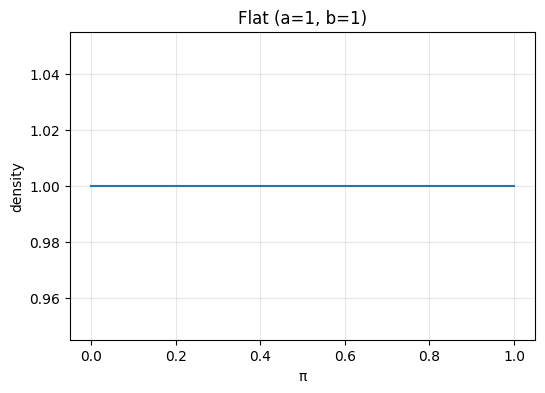

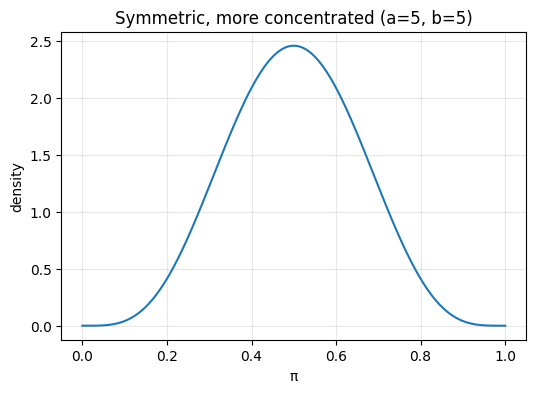

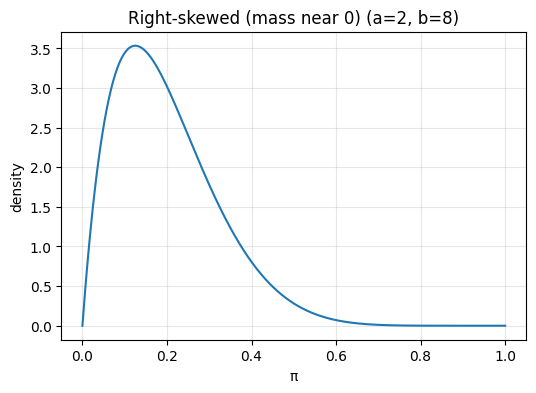

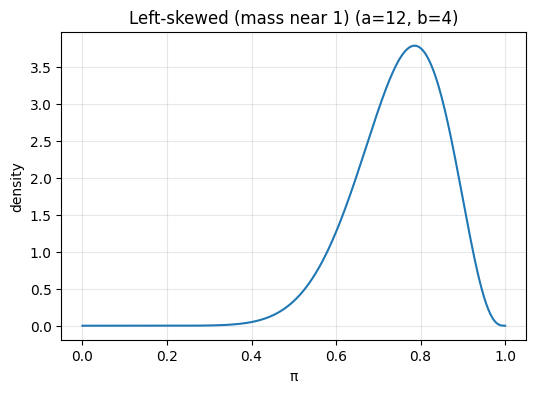

In [19]:
def beta_pdf(x, a, b):
    from math import lgamma
    x = np.asarray(x)
    out = np.zeros_like(x, dtype=float)
    mask = (x>=0) & (x<=1)
    xm = x[mask]
    logB = lgamma(a) + lgamma(b) - lgamma(a+b)
    out[mask] = np.exp((a-1)*np.log(xm + 1e-15) + (b-1)*np.log(1 - xm + 1e-15) - logB)
    return out

def beta_update(alpha, beta, n, k):
    return alpha + k, beta + (n - k)

def binom_like_curve(n, k):
    xs = np.linspace(0,1,500)
    ys = xs**k * (1-xs)**(n-k)
    ys /= (ys.max() + 1e-15)
    return xs, ys

def plot_beta(a, b, title="Beta prior"):
    xs = np.linspace(0,1,400)
    ys = beta_pdf(xs, a, b)
    fig, ax = with_ax(title=f"{title} (a={a}, b={b})", xlabel="π", ylabel="density")
    ax.plot(xs, ys)
    plt.show()

# Inspect a few priors
plot_beta(1,1, title="Flat")
plot_beta(5,5, title="Symmetric, more concentrated")
plot_beta(2,8, title="Right-skewed (mass near 0)")
plot_beta(12,4, title="Left-skewed (mass near 1)")


### Updating with data
Suppose the class reports $n=20$ people, of which $k=14$ can roll their tongue. Start with a flat prior $\mathrm{Beta}(1,1)$.


In [3]:

alpha0, beta0 = 1, 1
n, k = 20, 14
alpha1, beta1 = beta_update(alpha0, beta0, n, k)
alpha1, beta1


(15, 7)

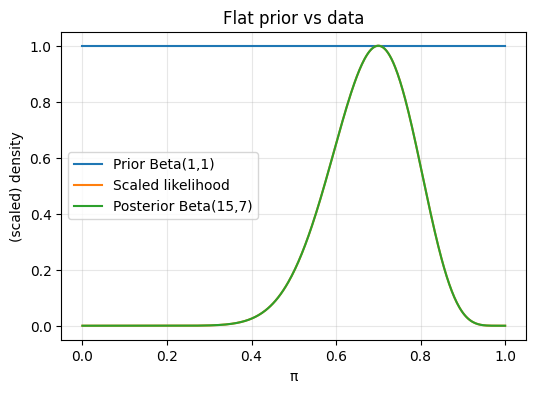

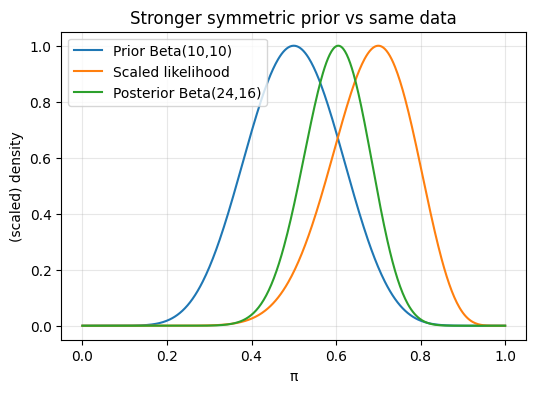

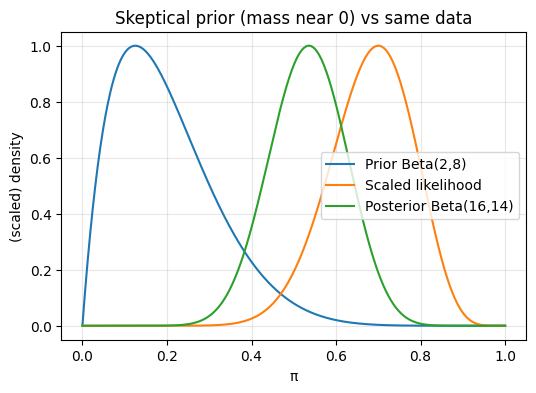

In [4]:

# Compare prior, scaled likelihood, and posterior
def show_update(alpha, beta, n, k, title=None):
    xs = np.linspace(0,1,500)
    prior = beta_pdf(xs, alpha, beta)
    like_xs, like = binom_like_curve(n, k)
    a1, b1 = beta_update(alpha, beta, n, k)
    post = beta_pdf(xs, a1, b1)

    fig, ax = with_ax(title=title or f"Beta–Binomial Update (n={n}, k={k})", xlabel="π", ylabel="(scaled) density")
    ax.plot(xs, prior/prior.max(), label=f"Prior Beta({alpha},{beta})")
    ax.plot(like_xs, like, label="Scaled likelihood")
    ax.plot(xs, post/post.max(), label=f"Posterior Beta({a1},{b1})")
    ax.legend(); plt.show()

show_update(1,1,n,k, "Flat prior vs data")
show_update(10,10,n,k, "Stronger symmetric prior vs same data")
show_update(2,8,n,k, "Skeptical prior (mass near 0) vs same data")



### Posterior summaries (sampling, no SciPy)


In [5]:
def beta_post_samples(alpha, beta, n, k, size=20000, seed=0):
    rng = np.random.default_rng(seed)
    a1, b1 = beta_update(alpha, beta, n, k)
    return rng.beta(a1, b1, size=size)

samps = beta_post_samples(1,1,n,k)
np.mean(samps), np.quantile(samps, [0.025,0.5,0.975])


(0.6818480508638697, array([0.47925049, 0.68767237, 0.85457469]))

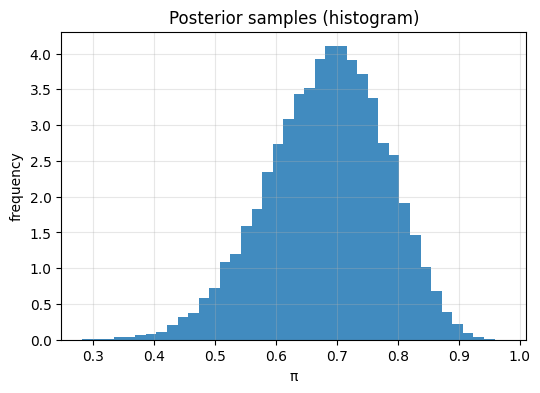

In [6]:

fig, ax = with_ax(title="Posterior samples (histogram)", xlabel="π", ylabel="frequency")
ax.hist(samps, bins=40, density=True, alpha=0.85)
plt.show()



### Data amount vs prior strength
- Larger $n$ $\Rightarrow$ narrower likelihood, posterior closer to data  
- Larger $\alpha+\beta$ $\Rightarrow$ stronger prior, more data needed to move it


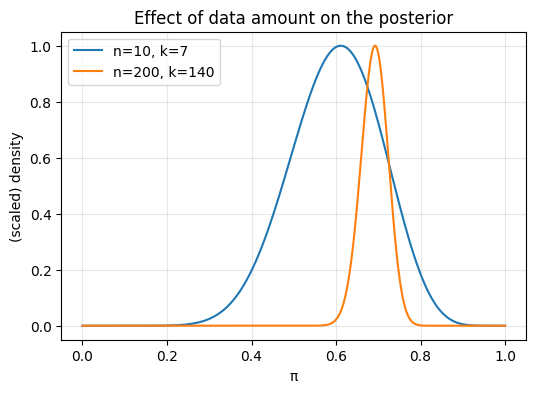

In [7]:
def compare_n(alpha, beta, n1, k1, n2, k2):
    xs = np.linspace(0,1,500)
    p1 = beta_pdf(xs, *beta_update(alpha,beta,n1,k1))
    p2 = beta_pdf(xs, *beta_update(alpha,beta,n2,k2))
    fig, ax = with_ax(title="Effect of data amount on the posterior", xlabel="π", ylabel="(scaled) density")
    ax.plot(xs, p1/p1.max(), label=f"n={n1}, k={k1}")
    ax.plot(xs, p2/p2.max(), label=f"n={n2}, k={k2}")
    ax.legend(); plt.show()

compare_n(5,5, n1=10,k1=7, n2=200,k2=140)



### Order of data does not matter
Two batches $(n_1,k_1)$ and $(n_2,k_2)$ give the same posterior as a single batch $(n_1+n_2,\ k_1+k_2)$.


In [8]:
def batch_update(alpha,beta,batches):
    a,b = alpha,beta
    for (n_i,k_i) in batches:
        a,b = beta_update(a,b,n_i,k_i)
    return a,b

alpha,beta = 1,1
b1 = [(10,6),(10,8)]
b2 = [(10,8),(10,6)]
batch_update(alpha,beta,b1), batch_update(alpha,beta,b2), beta_update(alpha,beta, 20,14)


((15, 7), (15, 7), (15, 7))


### Posterior simulation by rejection (concept demo)
A simple way to approximate $p(\pi \mid k)$ without formulas:

1. Sample $\pi_i \sim \mathrm{Beta}(\alpha,\beta)$  
2. Sample $y_i \sim \mathrm{Binomial}(n,\pi_i)$  
3. Keep $\pi_i$ with $y_i=k$  
4. The kept $\{\pi_i\}$ approximate the posterior


In [20]:
def rejection_posterior(alpha,beta,n,k, N=100000, seed=3):
    rng = np.random.default_rng(seed)
    pis = rng.beta(alpha,beta, size=N)
    ys  = rng.binomial(n, pis)
    kept = pis[ys==k]
    return kept

kept = rejection_posterior(1,1, n=10, k=7, N=200000, seed=9)
len(kept), np.mean(kept), np.quantile(kept, [0.025,0.5,0.975])


(18203, 0.6674821635599316, array([0.39180166, 0.67607326, 0.89314178]))

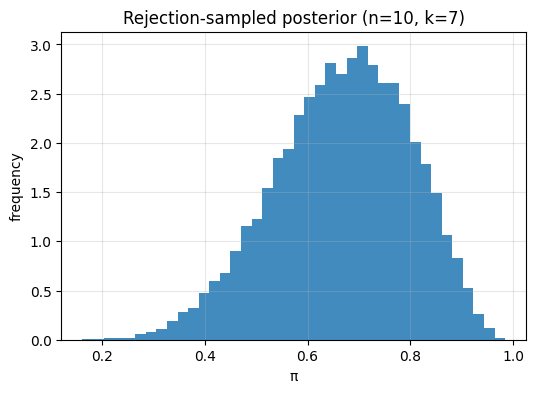

In [10]:

fig, ax = with_ax(title="Rejection-sampled posterior (n=10, k=7)", xlabel="π", ylabel="frequency")
ax.hist(kept, bins=40, density=True, alpha=0.85)
plt.show()


## Bechdel test example (Beta–Binomial)

Dataset: from $n=20$ movies since 1970, $k=9$ pass the Bechdel test. Compare three priors:

- **Clueless** (uninformed): $\mathrm{Beta}(1,1)$  
- **Feminist** (weakly informed): $\mathrm{Beta}(3,2)$  
- **Optimist** (more strongly informed): $\mathrm{Beta}(10,6)$

We visualize priors, the scaled likelihood, and posteriors to see the "compromise".


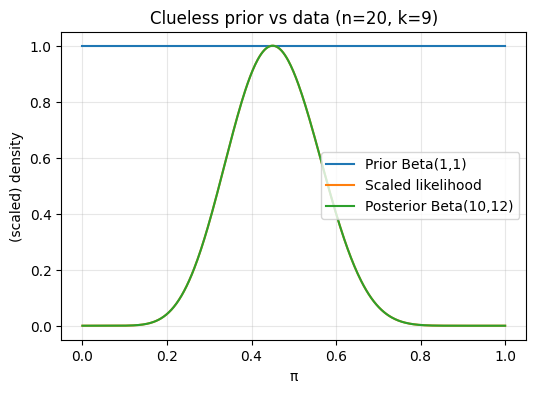

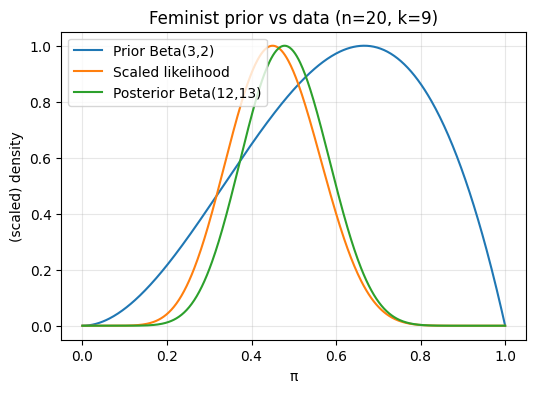

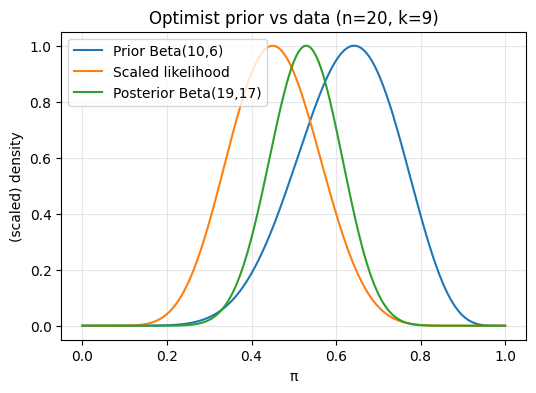

In [21]:
n_b, k_b = 20, 9
priors = [(1,1,"Clueless"), (3,2,"Feminist"), (10,6,"Optimist")]
for a,b,name in priors:
    show_update(a,b, n_b,k_b, f"{name} prior vs data (n={n_b}, k={k_b})")



### Decomposing the posterior mean
For $\pi \mid \text{data} \sim \mathrm{Beta}(\alpha+k, \beta+n-k)$,
$$
\mathbb{E}[\pi \mid \text{data}] \;=\; 
\frac{\alpha+k}{\alpha+\beta+n} \;=\;
w_{\text{prior}}\;\frac{\alpha}{\alpha+\beta}\;+\;
w_{\text{data}}\;\frac{k}{n},
$$
with weights $w_{\text{prior}}=\frac{\alpha+\beta}{\alpha+\beta+n}$ and $w_{\text{data}}=\frac{n}{\alpha+\beta+n}$.  
- Large $n$: data weight dominates (empirical rate)  
- Small $n$: prior weight dominates  
- Larger $\alpha+\beta$: prior is stronger, needs more data to move


In [12]:
def beta_posterior_mean(alpha,beta,n,k):
    return (alpha + k)/(alpha + beta + n)

def weights(alpha,beta,n):
    w_prior = (alpha+beta)/(alpha+beta+n)
    w_data  = n/(alpha+beta+n)
    return w_prior, w_data

alpha, beta, n, k = 3, 2, 20, 9
beta_posterior_mean(alpha,beta,n,k), weights(alpha,beta,n), (alpha/(alpha+beta), k/n)


(0.48, (0.2, 0.8), (0.6, 0.45))


## Counts example: Self-checkout queue (Gamma–Poisson)

We observe queue sizes $y = [6,4,0,2,3,2,4,4,6,4]$. Model counts as Poisson with rate $\lambda>0$.

- Likelihood $\propto \lambda^{\sum y_i} e^{-n\lambda}$  
- Prior $\lambda \sim \mathrm{Gamma}(s,r)$ in **shape–rate** form: $p(\lambda)\propto \lambda^{s-1} e^{-r\lambda}$  
- **Posterior**: $\mathrm{Gamma}(s+\sum y_i,\ r+n)$

Use the elicited prior $s=1.8, r=1.0$ and update with the data.


In [13]:
def gamma_pdf(x, s, r):
    from math import lgamma
    x = np.asarray(x)
    out = np.zeros_like(x, dtype=float)
    m = x>0
    xm = x[m]
    out[m] = np.exp((s-1)*np.log(xm) - r*xm - (lgamma(s) - s*np.log(r)))
    return out

def gamma_poisson_update(s,r, ys):
    return s + np.sum(ys), r + len(ys)

ys = np.array([6,4,0,2,3,2,4,4,6,4])
s0, r0 = 1.8, 1.0
s1, r1 = gamma_poisson_update(s0,r0, ys)
s1, r1


(36.8, 11.0)

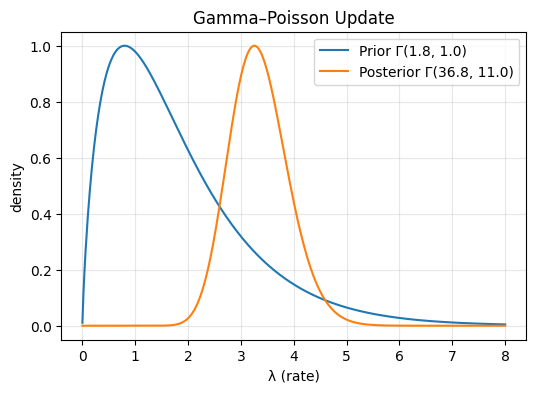

In [14]:
xs = np.linspace(0.001, 8, 400)
prior = gamma_pdf(xs, s0, r0)
post  = gamma_pdf(xs, s1, r1)

fig, ax = with_ax(title="Gamma–Poisson Update", xlabel="λ (rate)", ylabel="density")
ax.plot(xs, prior/prior.max(), label=f"Prior Γ({s0}, {r0})")
ax.plot(xs, post/post.max(),   label=f"Posterior Γ({s1:.1f}, {r1:.1f})")
ax.legend(); plt.show()


In [15]:
# Posterior summaries via sampling
rng = np.random.default_rng(42)
lam_samps = rng.gamma(shape=s1, scale=1.0/r1, size=20000)  # shape–scale for numpy
lam_samps.mean(), np.quantile(lam_samps, [0.025,0.5,0.975])


(3.3489462388951563, array([2.35113087, 3.31908862, 4.52326014]))


## Normal–Normal (mean with known variance)

Assume $y_i \sim \mathcal{N}(\mu, \sigma^2)$ with **known** $\sigma^2$ and prior $\mu \sim \mathcal{N}(\mu_0, \tau_0^2)$.  
Then
$$
\mu \mid y \sim \mathcal{N}(\mu_n, \tau_n^2), \qquad
\tau_n^2 \;=\; \left(\frac{1}{\tau_0^2} + \frac{n}{\sigma^2}\right)^{-1}, \quad
\mu_n \;=\; \tau_n^2 \left(\frac{\mu_0}{\tau_0^2} + \frac{n\bar y}{\sigma^2}\right).
$$

This case is pedagogical (rarely is $\sigma^2$ known), but it illustrates conjugacy and weighting.


In [16]:

def normal_pdf(x, m, s):
    return 1.0/(math.sqrt(2*math.pi)*s) * np.exp(-0.5*((x-m)/s)**2)

def normal_normal_update(mu0, tau0, ybar, n, sigma):
    tau_n2 = 1.0 / (1.0/tau0**2 + n/(sigma**2))
    mu_n = tau_n2 * (mu0/(tau0**2) + n*ybar/(sigma**2))
    return mu_n, math.sqrt(tau_n2)

# Example
rng = np.random.default_rng(7)
sigma = 2.0
true_mu = 1.5
y = rng.normal(true_mu, sigma, size=30)
mu0, tau0 = 0.0, 5.0
mu_n, tau_n = normal_normal_update(mu0, tau0, y.mean(), len(y), sigma)
mu_n, tau_n


(0.6682963672094672, 0.3641785203646149)

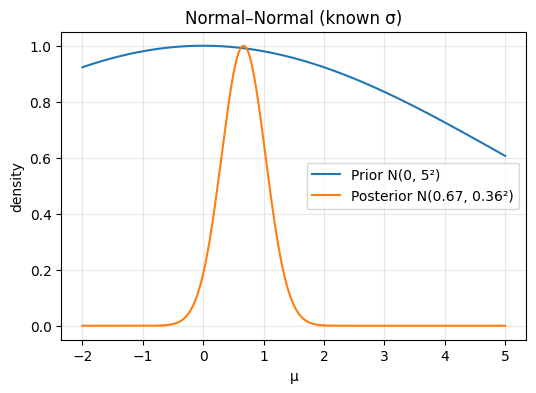

In [17]:

xs = np.linspace(-2,5,400)
prior = normal_pdf(xs, 0.0, 5.0)
post  = normal_pdf(xs, mu_n, tau_n)

fig, ax = with_ax(title="Normal–Normal (known σ)", xlabel="μ", ylabel="density")
ax.plot(xs, prior/prior.max(), label="Prior N(0, 5²)")
ax.plot(xs, post/post.max(),   label=f"Posterior N({mu_n:.2f}, {tau_n:.2f}²)")
ax.legend(); plt.show()



## Key takeaways & what to try next
- **Conjugacy** gives closed-form updates (great for intuition).  
- Beta–Binomial, Gamma–Poisson, and Normal–Normal each show how priors and data trade off.  
- **Evidence** normalizes the posterior; it's crucial in model comparison.  
- When closed forms are unavailable, use **sampling** (this will be our path forward).

**Try:** change priors, alter $n$ and $k$, plug in your own count data, or compare weak vs strong priors.
